# Informazioni consegna
* Aggiungere i componenti del proprio gruppo in questo [form](https://forms.office.com/r/1WKBx4YgSH). 
* **I gruppi possono essere composti da massimo 3 persone. Nel caso si intenda fare il progetto da soli bisogna comunque aggiungere il proprio nome nel form.**
* Per la consegna è necessario caricare su Virtuale la relazione, il notebook Colab e le immagini generate.
* La consegna deve essere effettuata da un qualsiasi membro del gruppo e verrà automaticamente attribuita ai restanti componenti.
* Per i dettagli sulle tempistiche e le scadenze si faccia riferimento a Virtuale.

# Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

## Funzioni di blur
Le seguenti funzioni servono per applicare il blur di tipo gaussiano ad un'immagine.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
from scipy.optimize import minimize

# Create a Gaussian kernel of size kernlen and standard deviation sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

# Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary
# to match the size of 'shape'
def psf_fft(K, d, shape):
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Multiplication by A transpose
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

## Generazione dataset
Generare un set di 8 immagini 512 $\times$ 512 in formato ${\tt png}$ in scala dei grigi che contengano tra i 2 ed i 6 oggetti geometrici, di colore uniforme, su sfondo nero. 


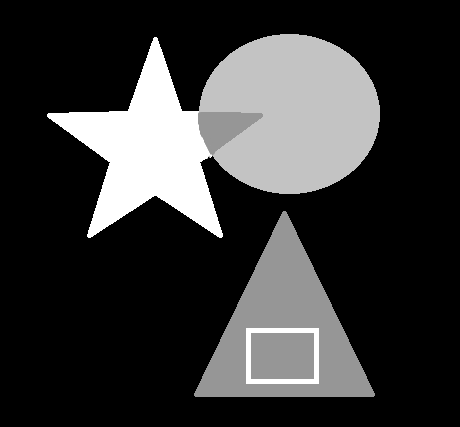


In [2]:
plt.rcParams.update({'font.size': 15})

## 1) Generazione immagini corrotte
Degradare le immagini applicando, mediante le funzioni riportate nella cella precedente,  l'operatore di blur con parametri

+ $\sigma=0.5$ dimensione $5\times 5$
+ $\sigma=1$ dimensione $7\times 7$
+ $\sigma=1.3$ dimensione $9\times 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0,0.05]$

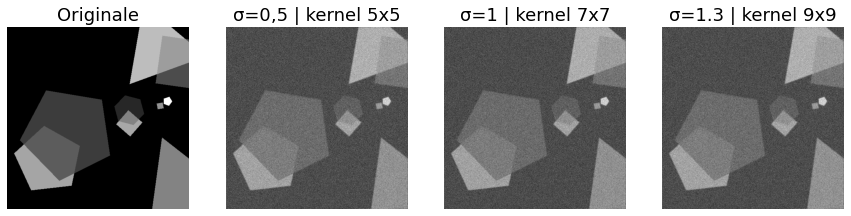

In [138]:
def gaussian_blur(image_size, kernel_len, sigma): 
    return psf_fft(gaussian_kernel(kernel_len, sigma), kernel_len, image_size)

# real_image = data.camera().astype(np.float64) / 255.0
real_image = plt.imread("./dataset/image1.png").astype(np.float64)

# Filtro blur (A)
# blur1 = gaussian_blur(real_image.shape, 5, 0.5)
blur1 = gaussian_blur(real_image.shape, 9, 1.3)
# blur1 = gaussian_blur(real_image.shape, 24, 3)
blur2 = gaussian_blur(real_image.shape, 7, 1)
blur3 = gaussian_blur(real_image.shape, 9, 1.3)

# Filtro rumore (η)
dev = 0.1
noise = np.random.normal(size=real_image.shape) * dev

image1 = A(real_image, blur1) + noise
image2 = A(real_image, blur2) + noise
image3 = A(real_image, blur3) + noise


fig, ax = plt.subplots(1, 4, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01)

ax[0].imshow(real_image, cmap="gray")
ax[0].set_title("Originale")
ax[0].axis("off")

ax[1].imshow(image1, cmap="gray")
ax[1].set_title("σ=0,5 | kernel 5x5")
ax[1].axis("off")

ax[2].imshow(image2, cmap="gray")
ax[2].set_title("σ=1 | kernel 7x7")
ax[2].axis("off")

ax[3].imshow(image3, cmap="gray")
ax[3].set_title("σ=1.3 | kernel 9x9")
ax[3].axis("off")

plt.show()


## 2) Soluzione naive

Una possibile ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

La funzione $f$ da minimizzare è data dalla formula
  $f(x) = \frac{1}{2} ||Ax - b||_2^2 $, il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb  $.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` calcolare la soluzione naive. 

In [4]:
def f_naive(x, image, blur):
    x = x.reshape(image.shape)
    return (1 / 2) * (np.linalg.norm(A(x, blur) - image)**2)

def df_naive(x, image, blur):
    x = x.reshape(image.shape)
    return (AT(A(x, blur), blur) - AT(image, blur)).reshape(-1)

In [5]:
def deblur_naive(image, blur, tol=None, max_iter=1000, callback=None):
    def f(x):
        return f_naive(x, image, blur)
    def df(x):
        return df_naive(x, image, blur)

    out = minimize(
        fun = f, 
        x0=np.zeros(image.size),
        method = "CG",
        jac = df,
        tol = tol,
        options = {"maxiter": max_iter}, 
        callback = callback
    )

    return { "image": out.x.reshape(image.shape), "n_it": out.nit }

## 3) Regolarizzazione

Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}

La funzione $f$ da minimizzare diventa
$f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2$
il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb + λx$.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` ed il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 

In [6]:
def f_tikhonov(x, image, blur, lamb):
    x = x.reshape(image.shape)
    return (1 / 2) * (np.linalg.norm(A(x, blur) - image)**2) + (lamb / 2) * (np.linalg.norm(x)**2)


def df_tikhonov(x, image, blur, lamb):
    x = x.reshape(image.shape)
    return (AT(A(x, blur), blur) - AT(image, blur) + (lamb * x)).reshape(-1)

In [7]:
def deblur_tikhonov_cg(image, blur, lamb, tol=None, max_iter=1000, callback=None):
    def f(x):
        return f_tikhonov(x, image, blur, lamb)
    def df(x):
        return df_tikhonov(x, image, blur, lamb)

    out = minimize(
        fun = f, 
        x0 = np.zeros(image.size),
        method = "CG",
        jac = df,
        tol = tol,
        options = {"maxiter": max_iter}, 
        callback = callback
    )

    return { "image": out.x.reshape(image.shape), "n_it": out.nit }


In [8]:
def next_step(f, x, grad):  # backtracking procedure for the choice of the steplength
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  p = -grad
  j = 0
  jmax = 10
  while ((f(x+alpha*p) > f(x) + c1 * alpha * grad.T @ p) and j < jmax):
    alpha = rho * alpha
    j += 1
  if (j > jmax):
    return -1
  else:
    return alpha

def gradiente(f, grad_f, x0, step, MAXITERATION, ABSOLUTE_STOP, callback):
  # initialize first values
  x_last = np.array(x0)
  
  k = 0
  while (np.linalg.norm(grad_f(x_last)) > ABSOLUTE_STOP and k < MAXITERATION ):
    k = k+1
    grad = grad_f(x_last)

    # backtracking step
    step = next_step(f, x_last, grad)
    
    if (step == -1):
      print('non convergente')
      return (k) # no convergence

    x_last= x_last - step*grad
    
    if callback is not None:
      callback(x_last)
 
  return (x_last, k)


def deblur_tikhonov_gd(image, blur, lamb, tol=1.e-5, max_iter=1000, callback=None):
  def f(x):
      return f_tikhonov(x, image, blur, lamb)
  def df(x):
      return df_tikhonov(x, image, blur, lamb)

  x0 = np.zeros(image.size)

  out, n_it = gradiente(
      f = f,
      grad_f = df,
      x0 = x0,
      step = next_step(f, x0, df(x0)),
      MAXITERATION = max_iter,
      ABSOLUTE_STOP = tol, 
      callback = callback
  )

  return {"image": out.reshape(image.shape), "n_it": n_it}


## 4) Variazione Totale (Facoltativo) 

Un'altra funzione adatta come termine di regolarizzazione è la Variazione Totale. Data $u$ immagine di dimensioni $m\times n$ la variazione totale $TV$ di $u$ è definit come:
\begin{align*}
  TV(u) = \sum_i^n{\sum_j^m{\sqrt{||\nabla u(i, j)||_2^2 + \epsilon^2}}}
\end{align*}
Per calcolare il gradiente dell'immagine $\nabla u$ usiamo la funzione `np.gradient` che approssima la derivata per ogni pixel calcolando la differenza tra pixel adiacenti. I risultati sono due immagini della stessa dimensione dell'immagine in input, una che rappresenta il valore della derivata orizzontale `dx` e l'altra della derivata verticale `dy`. Il gradiente dell'immagine nel punto $(i, j)$ è quindi un vettore di due componenti, uno orizzontale contenuto in `dx` e uno verticale in `dy`.

Come nei casi precedenti il problema di minimo che si va a risolvere è il seguente:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda TV(u)
\end{align*}
il cui gradiente $\nabla f$ è dato da
\begin{align*}
\nabla f(x) = (A^TAx - A^Tb)  + \lambda \nabla TV(x)
\end{align*}

Utilizzando il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 


---
Per risolvere il problema di minimo è necessario anche calcolare il gradiente della variazione totale che è definito nel modo seguente
\begin{align*}
  \nabla TV(u) = -div\left(\frac{\nabla u}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}\right)
\end{align*}

\begin{align*}
  div(F) = \frac{\partial F_x}{\partial x} + \frac{\partial F_y}{\partial y}
\end{align*}

$div(F)$ è la divergenza del campo vettoriale $F$, nel nostro caso $F$ ha due componenti dati dal gradiente dell'immagine $\nabla u$ scalato per il valore $ \frac{1}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}$. Per calcolare la divergenza bisogna calcolare la derivata orizzontale $\frac{\partial F_x}{\partial x}$ della componente $x$ di $F$ e sommarla alla derivata verticale $\frac{\partial F_y}{\partial y}$ della componente $y$ di $F$. Per specificare in quale direzione calcolare la derivata con la funzione `np.gradient` utilizziamo il parametro `axis = 0` per l'orizzontale e `axis = 1` per la verticale.

In [9]:
eps = 1e-2

# Variazione totale
def totvar(x):
  # Calcola il gradiente di x
  dx, dy = np.gradient(x)
  n2 = np.square(dx) + np.square(dy)

  # Calcola la variazione totale di x
  tv = np.sqrt(n2 + eps**2).sum()
  return tv

# Gradiente della variazione totale
def grad_totvar(x):
  # Calcola il numeratore della frazione
  dx, dy = np.gradient(x)

  # Calcola il denominatore della frazione
  n2 = np.square(dx) + np.square(dy)
  den = np.sqrt(n2 + eps**2)

  # Calcola le due componenti di F dividendo il gradiente per il denominatore
  Fx = dx / den
  Fy = dy / den

  # Calcola la derivata orizzontale di Fx 
  dFdx = np.gradient(Fx, axis=0)
  
  # Calcola la derivata verticale di Fy
  dFdy = np.gradient(Fy, axis=1)

  # Calcola la divergenza 
  div = (dFdx + dFdy)

  # Restituisci il valore del gradiente della variazione totale
  return -div


In [10]:
def f_tv(x, image, blur, lamb):
    x = x.reshape(image.shape)
    return (1 / 2) * (np.linalg.norm(A(x, blur) - image)**2) + (lamb * totvar(x))


def df_tv(x, image, blur, lamb):
    x = x.reshape(image.shape)
    return ((AT(A(x, blur), blur)-AT(image, blur)) + (lamb*grad_totvar(x)) ).reshape(-1)


In [11]:
def deblur_tv(image, blur, lamb, tol=None, max_iter=1000, callback=None):
    def f(x):
        return f_tv(x, image, blur, lamb)
    def df(x):
        return df_tv(x, image, blur, lamb)

    out = minimize(
        fun = f,
        x0=np.zeros(image.size),
        method = "CG",
        jac = df,
        tol = tol,
        options = {"maxiter": max_iter},
        callback = callback
    )

    return { "image": out.x.reshape(image.shape), "n_it": out.nit }


<hr>

In [12]:
# Solo per fermare il run all
while True:
    pass

KeyboardInterrupt: 

# Analisi dei metodi regolarizzati

Analisi delle prestazioni dei metodi regolarizzati al variare di $\lambda$. \
Viene eseguita una valutazione su un ampio intervallo e poi più nel dettaglio nell'intorno del punto migliore trovato.

In [170]:
# Plot del PSNR al variare di lambda
def plot_lambda_difference(x, y, title):
    max_i = y.index(max(y))  # Indice del punto migliore

    plt.figure(figsize=(10, 6), dpi=80)

    plt.grid()
    plt.title(title)
    plt.xlabel("λ")
    plt.ylabel("PSNR")

    # PSNR al variare di lambda
    plt.plot(x, y)

    # Punto migliore
    plt.plot(x[max_i], y[max_i], "*") 
    plt.annotate(f" λ ≈ {round(x[max_i], 5)}", (x[max_i], y[max_i]))
    
    plt.show()


curr_image = image1
curr_blur = blur1

curr_image = images[0]
curr_blur = blurs[0]


## Tikhonov con gradiente coniugato

0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 

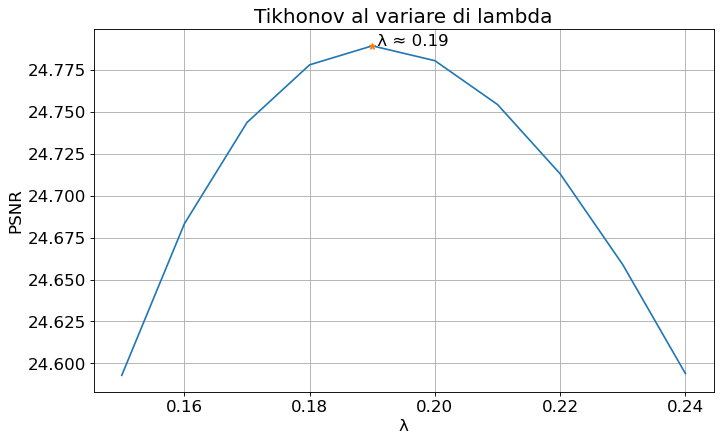

lambda = 0.19000000000000003 | PSNR = 24.789464591363807


In [172]:
# x_tikhonov1 = np.arange(0.01, 1, 0.01)
# x_tikhonov1 = np.arange(0.01, 0.3, 0.05)
x_tikhonov1 = np.arange(0.15, 0.25, 0.01)
y_tikhonov1 = []

for lamb in x_tikhonov1:
    print(round(lamb, 3), end=" ")
    out = deblur_tikhonov_cg(curr_image, curr_blur, lamb)
    y_tikhonov1 = y_tikhonov1 + [metrics.peak_signal_noise_ratio(real_image, out["image"])]


plot_lambda_difference(x_tikhonov1, y_tikhonov1, "Tikhonov al variare di lambda")

max_i = y_tikhonov1.index(max(y_tikhonov1))  # Indice del punto migliore
print(f"lambda = {x_tikhonov1[max_i]} | PSNR = {y_tikhonov1[max_i]}")
tikhonov_best = x_tikhonov1[max_i]


## Variazione totale

0.05 0.06 0.07 0.08 

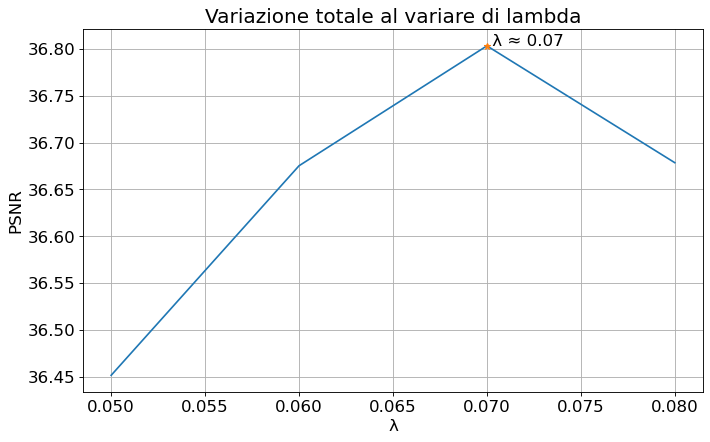

lambda = 0.07 | PSNR = 36.80336242491669


In [175]:
# x_tv1 = np.arange(0.01, 1, 0.01)
# x_tv1 = np.arange(0.01, 0.3, 0.05)
x_tv1 = np.arange(0.05, 0.09, 0.01)
y_tv1 = []

for lamb in x_tv1:
    print(round(lamb, 3), end=" ")
    out = deblur_tv(curr_image, curr_blur, lamb)
    y_tv1 = y_tv1 + [metrics.peak_signal_noise_ratio(real_image, out["image"])]


plot_lambda_difference(x_tv1, y_tv1, "Variazione totale al variare di lambda")

max_i = y_tv1.index(max(y_tv1))  # Indice del punto migliore
print(f"lambda = {x_tv1[max_i]} | PSNR = {y_tv1[max_i]}")
tv_best = x_tv1[max_i]

# Esecuzione preliminare

Esecuzione dei metodi applicati ad un'immagine per una prima valutazione delle prestazioni dei metodi

In [ ]:
curr_image = image1
curr_blur = blur1
lambda_tikhonov = tikhonov_best
lambda_tv = round(tv_best, 2)
# lambda_tikhonov = 0.19
# lambda_tv = 0.07
# lambda_tikhonov = 0.09
# lambda_tv = 0.04
# lambda_tikhonov = 1e-3
# lambda_tv = 1e-3

out_naive = deblur_naive(curr_image, curr_blur, max_iter=200)
print("Done - Naive")
out_tikhonov_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov)
print("Done - Tikhonov CG")
out_tikhonov_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov)
print("Done - Tikhonov GD")
out_tv = deblur_tv(curr_image, curr_blur, lambda_tv)
print("Done - TV")


Done - Naive
Done - Tikhonov CG
Done - Tikhonov GD
Done - TV


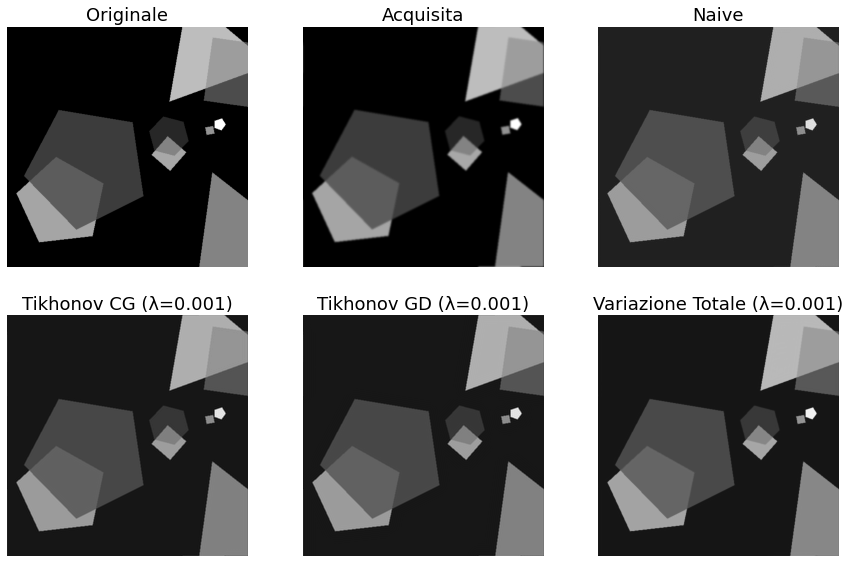

MSE originale/acquisita             0.0006990501435033874
MSE originale/naive                 0.0002163713223541777
MSE originale/Tikhonov1             0.0002694407509771702
MSE originale/Tikhonov2             0.0002728691000149669
MSE originale/Variazione totale     8.945935742097168e-05

PSNR originale/acquisita            31.554916707982926
PSNR originale/naive                36.64800300721913
PSNR originale/Tikhonov1            35.695367197262186
PSNR originale/Tikhonov2            35.6404564151146
PSNR originale/Variazione totale    40.483742256528366

Iterazioni naive                    135
Iterazioni Tikhonov CG              62
Iterazioni Tikhonov GD              1000
Iterazioni Variazione totale        35


In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01)

ax[0, 0].imshow(real_image, cmap="gray")
ax[0, 0].set_title("Originale")
ax[0, 0].axis("off")

ax[0, 1].imshow(curr_image, cmap="gray")
ax[0, 1].set_title("Acquisita")
ax[0, 1].axis("off")

ax[0, 2].imshow(out_naive["image"], cmap="gray")
ax[0, 2].set_title(f"Naive")
ax[0, 2].axis("off")

ax[1, 0].imshow(out_tikhonov_cg["image"], cmap="gray")
ax[1, 0].set_title(f"Tikhonov CG (λ={lambda_tikhonov})")
ax[1, 0].axis("off")

ax[1, 1].imshow(out_tikhonov_gd["image"], cmap="gray")
ax[1, 1].set_title(f"Tikhonov GD (λ={lambda_tikhonov})")
ax[1, 1].axis("off")

ax[1, 2].imshow(out_tv["image"], cmap="gray")
ax[1, 2].set_title(f"Variazione Totale (λ={lambda_tv})")
ax[1, 2].axis("off")

plt.show()

print(f"{'MSE originale/acquisita':<35} {metrics.mean_squared_error(real_image, curr_image)}")
print(f"{'MSE originale/naive':<35} {metrics.mean_squared_error(real_image, out_naive['image'])}")
print(f"{'MSE originale/Tikhonov1':<35} {metrics.mean_squared_error(real_image, out_tikhonov_cg['image'])}")
print(f"{'MSE originale/Tikhonov2':<35} {metrics.mean_squared_error(real_image, out_tikhonov_gd['image'])}")
print(f"{'MSE originale/Variazione totale':<35} {metrics.mean_squared_error(real_image, out_tv['image'])}")
print()
print(f"{'PSNR originale/acquisita':<35} {metrics.peak_signal_noise_ratio(real_image, curr_image)}")
print(f"{'PSNR originale/naive':<35} {metrics.peak_signal_noise_ratio(real_image, out_naive['image'])}")
print(f"{'PSNR originale/Tikhonov1':<35} {metrics.peak_signal_noise_ratio(real_image, out_tikhonov_cg['image'])}")
print(f"{'PSNR originale/Tikhonov2':<35} {metrics.peak_signal_noise_ratio(real_image, out_tikhonov_gd['image'])}")
print(f"{'PSNR originale/Variazione totale':<35} {metrics.peak_signal_noise_ratio(real_image, out_tv['image'])}")
print()
print(f"{'Iterazioni naive':<35} {out_naive['n_it']}")
print(f"{'Iterazioni Tikhonov CG':<35} {out_tikhonov_cg['n_it']}")
print(f"{'Iterazioni Tikhonov GD':<35} {out_tikhonov_gd['n_it']}")
print(f"{'Iterazioni Variazione totale':<35} {out_tv['n_it']}")


# Confronto prestazioni Tikhonov con Gradiente Coniugato e Metodo del Gradiente

Analisi del comportamento dei metodi con discesa CG e GD al variare della tolleranza in termini di errore e numero di iterazioni.

In [ ]:
# curr_image = image1
# curr_blur = blur1
# lambda_tikhonov = tikhonov_best
# lambda_tv = round(tv_best, 2)


## Numero di iterazioni

In [ ]:
tols = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

n_it_cg = []
n_it_gd = []
psnr_cg = []
psnr_gd = []

for tol in tols:
    print(tol, end=" ")
    out_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov, tol=tol)
    n_it_cg = n_it_cg + [out_cg["n_it"]]
    psnr_cg = psnr_cg + [metrics.peak_signal_noise_ratio(real_image, out_cg["image"])]
    
    out_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov, tol=tol)
    n_it_gd = n_it_gd + [out_gd["n_it"]]
    psnr_gd = psnr_gd + [metrics.peak_signal_noise_ratio(real_image, out_gd["image"])]


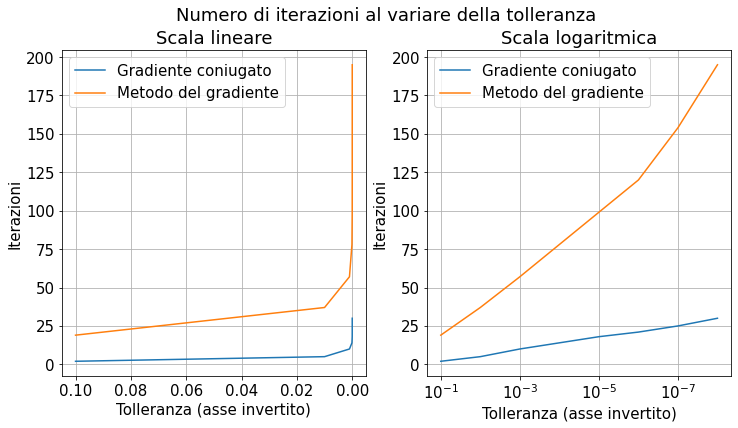

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("Numero di iterazioni al variare della tolleranza")

ax[0].grid()
ax[0].set_title("Scala lineare")
ax[0].set_xlabel("Tolleranza (asse invertito)")
ax[0].set_ylabel("Iterazioni")
ax[0].invert_xaxis()
ax[0].plot(tols, n_it_cg, label="Gradiente coniugato")
ax[0].plot(tols, n_it_gd, label="Metodo del gradiente")
ax[0].legend()

ax[1].grid()
ax[1].set_title("Scala logaritmica")
ax[1].set_xlabel("Tolleranza (asse invertito)")
ax[1].set_ylabel("Iterazioni")
ax[1].invert_xaxis()
ax[1].set_xscale('log')
ax[1].plot(tols, n_it_cg, label="Gradiente coniugato")
ax[1].plot(tols, n_it_gd, label="Metodo del gradiente")
ax[1].legend()

plt.show()


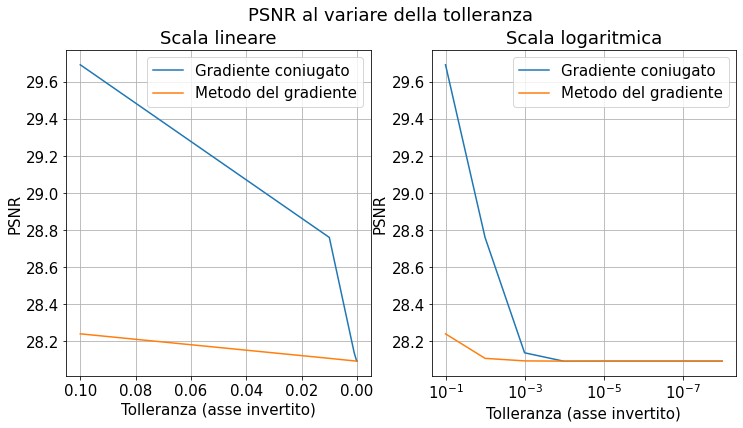

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("PSNR al variare della tolleranza")

ax[0].grid()
ax[0].set_title("Scala lineare")
ax[0].set_xlabel("Tolleranza (asse invertito)")
ax[0].set_ylabel("PSNR")
ax[0].invert_xaxis()
ax[0].plot(tols, psnr_cg, label="Gradiente coniugato")
ax[0].plot(tols, psnr_gd, label="Metodo del gradiente")
ax[0].legend()

ax[1].grid()
ax[1].set_title("Scala logaritmica")
ax[1].set_xlabel("Tolleranza (asse invertito)")
ax[1].set_ylabel("PSNR")
ax[1].invert_xaxis()
ax[1].set_xscale("log")
ax[1].plot(tols, psnr_cg, label="Gradiente coniugato")
ax[1].plot(tols, psnr_gd, label="Metodo del gradiente")
ax[1].legend()

plt.show()


## Funzione obiettivo / Norma del gradiente

In [ ]:
xk_cg = []
xk_gd = []

def append_cg(xk):
    global xk_cg
    xk_cg = xk_cg + [xk]


def append_gd(xk):
    global xk_gd
    xk_gd = xk_gd + [xk]


out_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov, callback=append_cg)
out_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov, callback=append_gd)

xk_cg = [np.zeros(curr_image.size)] + xk_cg
xk_gd = [np.zeros(curr_image.size)] + xk_gd

In [ ]:
f_k_cg = [f_tikhonov(xk, curr_image, curr_blur, lambda_tikhonov) for xk in xk_cg]
f_k_gd = [f_tikhonov(xk, curr_image, curr_blur, lambda_tikhonov) for xk in xk_gd]

df_k_cg = [np.linalg.norm(df_tikhonov(xk, curr_image, curr_blur, lambda_tikhonov)) for xk in xk_cg]
df_k_gd = [np.linalg.norm(df_tikhonov(xk, curr_image, curr_blur, lambda_tikhonov)) for xk in xk_gd]

diff_fgd_fcg = [f_k_gd[i] - f_k_cg[i] for i in range(len(f_k_cg))]
diff_dfgd_dfcg = [df_k_gd[i] - df_k_cg[i] for i in range(len(df_k_cg))]


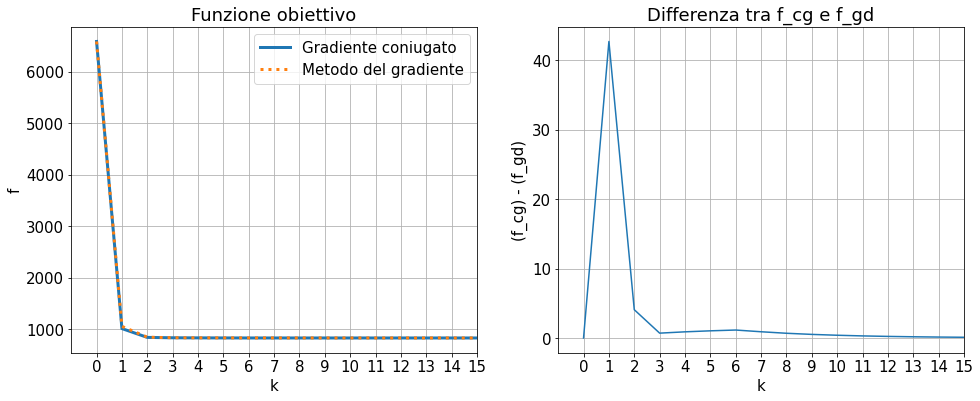

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].grid()
ax[0].set_title("Funzione obiettivo")
ax[0].set_xlabel("k")
ax[0].set_ylabel("f")
ax[0].plot(range(0, len(f_k_cg)), f_k_cg, label="Gradiente coniugato", linewidth=3)
ax[0].plot(range(0, len(f_k_gd)), f_k_gd, label="Metodo del gradiente", linestyle=":", linewidth=3)
ax[0].legend()
ax[0].set_xticks(range(0, len(f_k_gd)))
ax[0].set_xlim([-1, 15])

ax[1].grid()
ax[1].set_title("Differenza tra f_cg e f_gd")
ax[1].set_xlabel("k")
ax[1].set_ylabel("(f_cg) - (f_gd)")
ax[1].plot(range(0, len(diff_fgd_fcg)), diff_fgd_fcg)
ax[1].set_xticks(range(0, len(diff_fgd_fcg)))
ax[1].set_xlim([-1, 15])

plt.show()

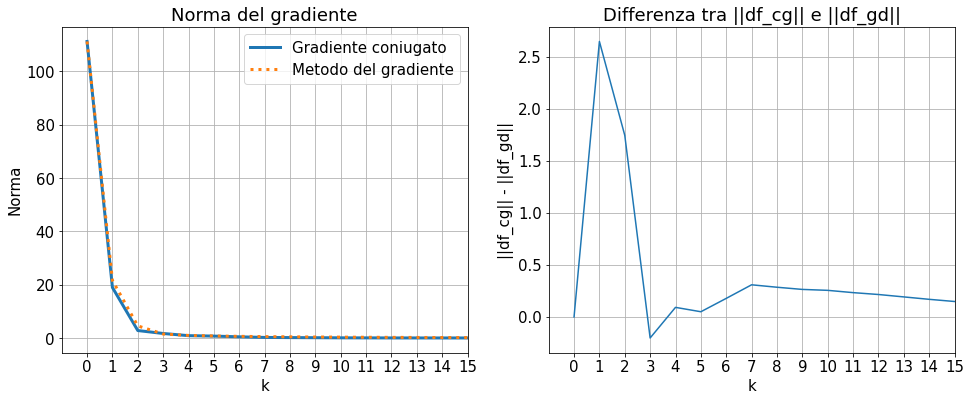

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].grid()
ax[0].set_title("Norma del gradiente")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Norma")
ax[0].plot(range(0, len(df_k_cg)), df_k_cg, label="Gradiente coniugato", linewidth=3)
ax[0].plot(range(0, len(df_k_gd)), df_k_gd, label="Metodo del gradiente", linestyle=":", linewidth=3)
ax[0].legend()
ax[0].set_xticks(range(0, len(df_k_gd)))
ax[0].set_xlim([-1, 15])

ax[1].grid()
ax[1].set_title("Differenza tra ||df_cg|| e ||df_gd||")
ax[1].set_xlabel("k")
ax[1].set_ylabel("||df_cg|| - ||df_gd||")
ax[1].plot(range(0, len(diff_dfgd_dfcg)), diff_dfgd_dfcg)
ax[1].set_xticks(range(0, len(diff_dfgd_dfcg)))
ax[1].set_xlim([-1, 15])

plt.show()


# Semi-convergenza

## Tikhonov

In [ ]:
xk_cg = []
xk_gd = []

def append_cg(xk):
    global xk_cg
    xk_cg = xk_cg + [xk]

def append_gd(xk):
    global xk_gd
    xk_gd = xk_gd + [xk]

out_cg = deblur_tikhonov_cg(curr_image, curr_blur, lambda_tikhonov, callback=append_cg)
out_gd = deblur_tikhonov_gd(curr_image, curr_blur, lambda_tikhonov, callback=append_gd)

xk_cg = [np.zeros(curr_image.size)] + xk_cg
xk_gd = [np.zeros(curr_image.size)] + xk_gd


In [ ]:
images_cg = [xk.reshape(curr_image.shape) for xk in xk_cg]
images_gd = [xk.reshape(curr_image.shape) for xk in xk_gd]

psnr_k_cg = [metrics.peak_signal_noise_ratio(real_image, image) for image in images_cg]
psnr_k_gd = [metrics.peak_signal_noise_ratio(real_image, image) for image in images_gd]

# mse_k_cg = [metrics.mean_squared_error(real_image, image) for image in images_cg]
# mse_k_gd = [metrics.mean_squared_error(real_image, image) for image in images_gd]
# norm_k_cg = [np.linalg.norm(real_image-image) for image in images_cg]
# norm_k_gd = [np.linalg.norm(real_image-image) for image in images_gd]

i_best_cg = psnr_k_cg.index(max(psnr_k_cg))
i_best_gd = psnr_k_gd.index(max(psnr_k_gd))


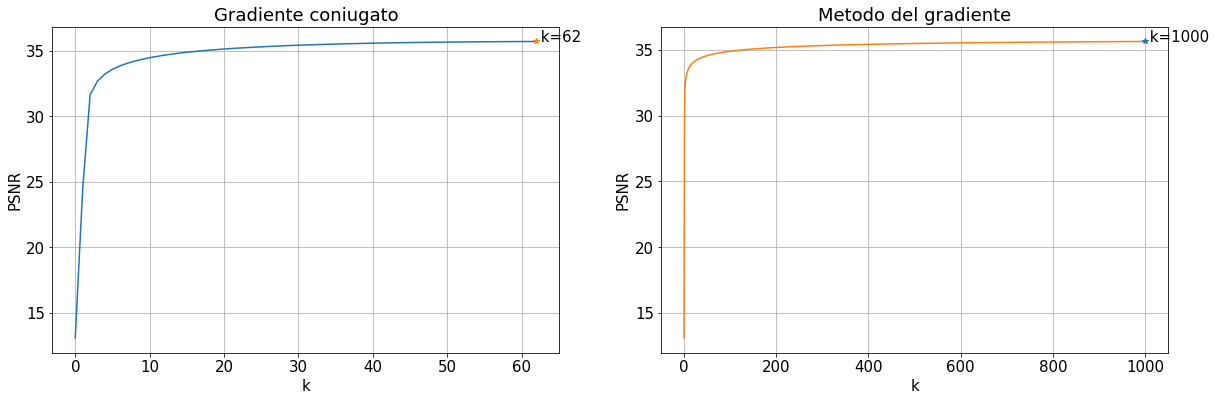

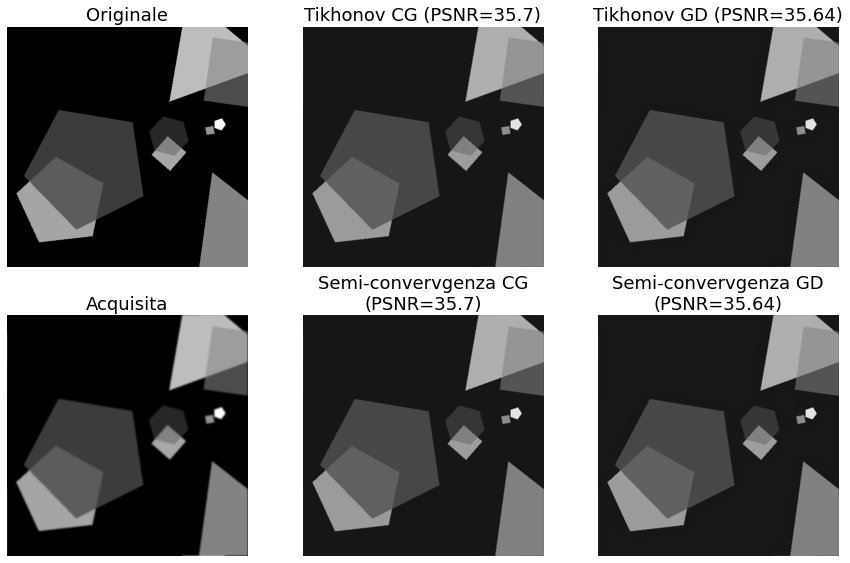

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].grid()
ax[0].set_title("Gradiente coniugato")
ax[0].set_xlabel("k")
ax[0].set_ylabel("PSNR")
ax[0].plot(range(0, len(psnr_k_cg)), psnr_k_cg, label="Gradiente coniugato")
ax[0].plot(i_best_cg, psnr_k_cg[i_best_cg], "*")
ax[0].annotate(f" k={i_best_cg}", (i_best_cg, psnr_k_cg[i_best_cg]))

ax[1].grid()
ax[1].set_title("Metodo del gradiente")
ax[1].set_xlabel("k")
ax[1].set_ylabel("PSNR")
ax[1].plot(range(0, len(psnr_k_gd)), psnr_k_gd, label="Metodo del gradiente", color="tab:orange")
ax[1].plot(i_best_gd, psnr_k_gd[i_best_gd], "*", color="tab:blue")
ax[1].annotate(f" k={i_best_gd}", (i_best_gd, psnr_k_gd[i_best_gd]))

plt.show()


fig, ax = plt.subplots(2, 3, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01)

ax[0, 0].imshow(real_image, cmap="gray")
ax[0, 0].set_title("Originale")
ax[0, 0].axis("off")
ax[1, 0].imshow(curr_image, cmap="gray")
ax[1, 0].set_title("Acquisita")
ax[1, 0].axis("off")
ax[0, 1].imshow(out_tikhonov_cg["image"], cmap="gray")
ax[0, 1].set_title(f"Tikhonov CG (PSNR={round(metrics.peak_signal_noise_ratio(real_image, out_tikhonov_cg['image']), 2)})")
ax[0, 1].axis("off")
ax[0, 2].imshow(out_tikhonov_gd["image"], cmap="gray")
ax[0, 2].set_title(f"Tikhonov GD (PSNR={round(metrics.peak_signal_noise_ratio(real_image, out_tikhonov_gd['image']), 2)})")
ax[0, 2].axis("off")

ax[1, 1].imshow(images_cg[i_best_cg], cmap="gray")
ax[1, 1].set_title(f"Semi-convervgenza CG\n(PSNR={round(psnr_k_cg[i_best_cg], 2)})")
ax[1, 1].axis("off")

ax[1, 2].imshow(images_gd[i_best_gd], cmap="gray")
ax[1, 2].set_title(f"Semi-convervgenza GD\n(PSNR={round(psnr_k_gd[i_best_gd], 2)})")
ax[1, 2].axis("off")

plt.show()


## Naive

In [ ]:
xk_naive = []

def append_naive(xk):
    global xk_naive
    xk_naive = xk_naive + [xk]

out_naive_semi = deblur_naive(curr_image, curr_blur, callback=append_naive, max_iter=200)

xk_naive = [np.zeros(curr_image.size)] + xk_naive

In [ ]:
images_naive = [xk.reshape(curr_image.shape) for xk in xk_naive]

psnr_k_naive = [metrics.peak_signal_noise_ratio(real_image, image) for image in images_naive]

i_best_naive = psnr_k_naive.index(max(psnr_k_naive))

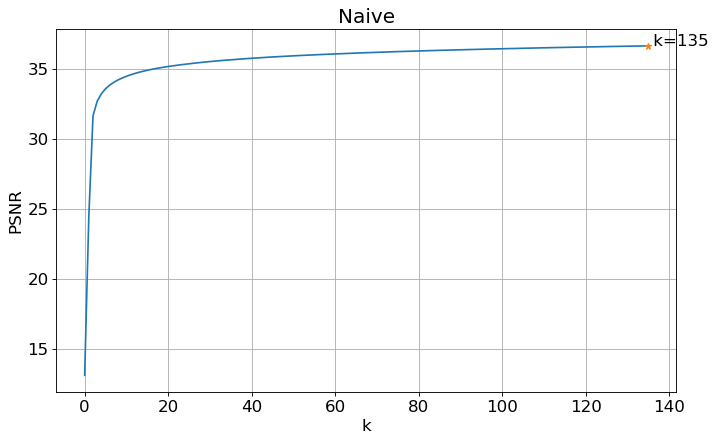

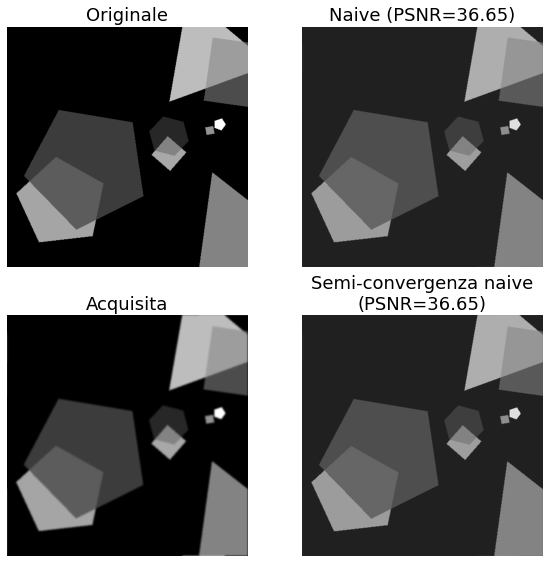

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)

plt.grid()
plt.title("Naive")
plt.xlabel("k")
plt.ylabel("PSNR")
plt.plot(range(0, len(psnr_k_naive)), psnr_k_naive, label="Naive")
plt.plot(i_best_naive, psnr_k_naive[i_best_naive], "*")
plt.annotate(f" k={i_best_naive}", (i_best_naive, psnr_k_naive[i_best_naive]))

plt.show()


fig, ax = plt.subplots(2, 2, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01, right=0.5, left=0)

ax[0, 0].imshow(real_image, cmap="gray")
ax[0, 0].set_title("Originale")
ax[0, 0].axis("off")
ax[1, 0].imshow(curr_image, cmap="gray")
ax[1, 0].set_title("Acquisita")
ax[1, 0].axis("off")
ax[0, 1].imshow(out_naive["image"], cmap="gray")
ax[0, 1].set_title(f"Naive (PSNR={round(metrics.peak_signal_noise_ratio(real_image, out_naive['image']), 2)})")
ax[0, 1].axis("off")

ax[1, 1].imshow(images_naive[i_best_naive], cmap="gray")
ax[1, 1].set_title(f"Semi-convergenza naive\n(PSNR={round(metrics.peak_signal_noise_ratio(real_image, images_naive[i_best_naive]), 2)})")
ax[1, 1].axis("off")

plt.show()


## Variazione totale

In [ ]:
xk_tv = []

def append_tv(xk):
    global xk_tv
    xk_tv = xk_tv + [xk]

out_tv_semi = deblur_tv(curr_image, curr_blur, lambda_tv, callback=append_tv)

xk_tv = [np.zeros(curr_image.size)] + xk_tv

In [ ]:
images_tv = [xk.reshape(curr_image.shape) for xk in xk_tv]

psnr_k_tv = [metrics.peak_signal_noise_ratio(real_image, image) for image in images_tv]

i_best_tv = psnr_k_tv.index(max(psnr_k_tv))

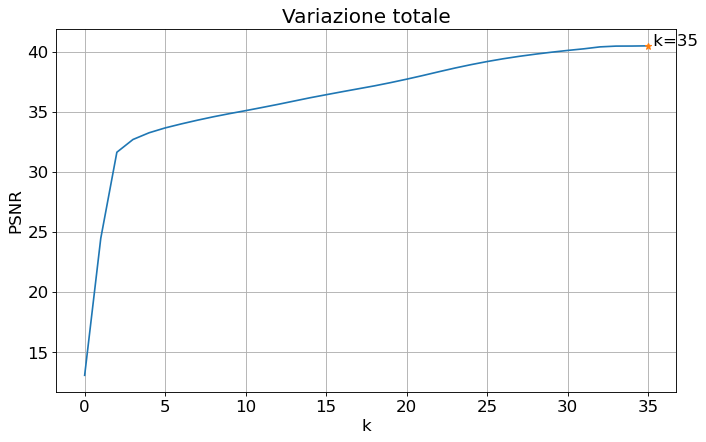

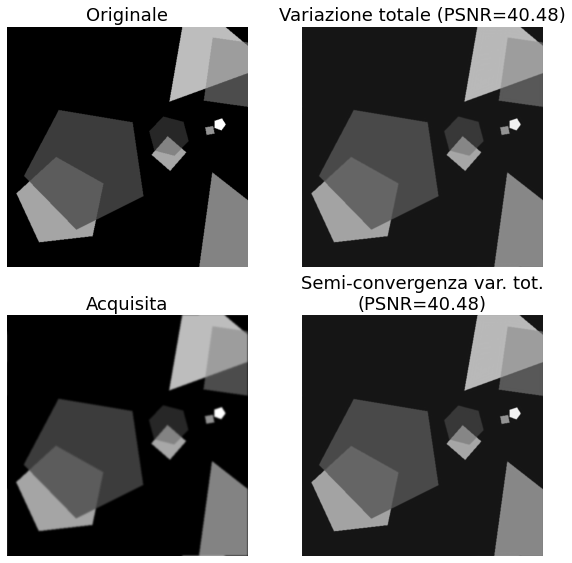

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)

plt.grid()
plt.title("Variazione totale")
plt.xlabel("k")
plt.ylabel("PSNR")
plt.plot(range(0, len(psnr_k_tv)), psnr_k_tv, label="tv")
plt.plot(i_best_tv, psnr_k_tv[i_best_tv], "*")
plt.annotate(f" k={i_best_tv}", (i_best_tv, psnr_k_tv[i_best_tv]))

plt.show()


fig, ax = plt.subplots(2, 2, figsize=(15, 15))
fig.subplots_adjust(top=0.5, bottom=0.01, right=0.5, left=0)

ax[0, 0].imshow(real_image, cmap="gray")
ax[0, 0].set_title("Originale")
ax[0, 0].axis("off")
ax[1, 0].imshow(curr_image, cmap="gray")
ax[1, 0].set_title("Acquisita")
ax[1, 0].axis("off")
ax[0, 1].imshow(out_tv["image"], cmap="gray")
ax[0, 1].set_title(f"Variazione totale (PSNR={round(metrics.peak_signal_noise_ratio(real_image, out_tv['image']), 2)})")
ax[0, 1].axis("off")

ax[1, 1].imshow(images_tv[i_best_tv], cmap="gray")
ax[1, 1].set_title(f"Semi-convergenza var. tot.\n(PSNR={round(metrics.peak_signal_noise_ratio(real_image, images_tv[i_best_tv]), 2)})")
ax[1, 1].axis("off")

plt.show()


In [ ]:
while True:
    pass

# Esecuzioni multiple

In [ ]:
from PIL import Image
from PIL import ImageDraw
import random
import math

# Restituisce la lista dei vertici di un poligono fissate alcuni valori
# Fonte: https://stackoverflow.com/questions/23411688/drawing-polygon-with-n-number-of-sides-in-python-3-2
def polygon(sides, radius=1, rotation=0, start_coord=(0, 0)):
    one_segment = math.pi * 2 / sides
    points = [(math.sin(one_segment * i + rotation) * radius, math.cos(one_segment * i + rotation) * radius) for i in range(sides)]
    points = [(point[0] + start_coord[0], point[1] + start_coord[1]) for point in points]
    return points

# Restituisce un'immagine contenente poligoni in scala di grigi normalizzata in [0, 1]
# width, height         Dimensione dell'immagine
# min_poygons           Numero minimo di poligoni generati
# max_polygons          Numero massimo di poligoni generati
# max_polygon_sides     Numero massimo di facce dei poligoni
def generate_image(width, height, min_poygons=3, max_polygons=6, max_polygon_sides=10):
    out_image = Image.new("RGBA", (width, height))
    num_polygons = random.randrange(min_poygons, max_polygons)

    for i in range(num_polygons):
        # Immagine che conterrà il nuovo poligono
        image = Image.new("RGBA", (width, height))
        draw = ImageDraw.Draw(image)

        # Generazione punti
        points = polygon(
            sides=random.randrange(3, max_polygon_sides),
            radius=random.randrange(int(width / 60), int(width / 3)),
            rotation=random.randrange(0, 359),
            start_coord=(random.randrange(0, width), random.randrange(0, height))
        )

        # Selezione colore
        color = (random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255), 150)
        draw.polygon((points), fill=color)

        # Sovrapposizione delle immagini
        out_image = Image.alpha_composite(out_image, image)

    # return out_image.convert("L")
    return np.array(out_image.convert("L")) / 255  # Immagine in scala di grigi normalizzata in [0, 1]


In [ ]:
psnr_naive = []
psnr_tikhonov = []
psnr_tv = []

iter_naive = []
iter_tikhonov = []
iter_tv = []

image_naive = []
image_tikhonov = []
image_tv = []


In [ ]:
for i in range(100):
    print(i, end=" ")
    real_image = generate_image(512, 512)

    # Applicazione blur e noise
    blur = gaussian_blur(real_image.shape, 9, 1.3)
    dev = 0.05
    noise = np.random.normal(size=real_image.shape) * dev
    image = A(real_image, blur) + noise

    # Esecuzione 
    out_naive = deblur_naive(image, blur, max_iter=100)
    out_tikhonov = deblur_tikhonov_cg(image, blur, 0.10)
    out_tv = deblur_tv(image, blur, 0.05)

    # PSNR
    psnr_naive = psnr_naive + [metrics.peak_signal_noise_ratio(real_image, out_naive["image"])]
    psnr_tikhonov = psnr_tikhonov + [metrics.peak_signal_noise_ratio(real_image, out_tikhonov["image"])]
    psnr_tv = psnr_tv + [metrics.peak_signal_noise_ratio(real_image, out_tv["image"])]

    # Numero iterazioni
    iter_naive = iter_naive + [out_naive["n_it"]]
    iter_tikhonov = iter_tikhonov + [out_tikhonov["n_it"]]
    iter_tv = iter_tv + [out_tv["n_it"]]

    # Immagine finale
    image_naive = image_naive + [out_naive["image"]]
    image_tikhonov = image_tikhonov + [out_tikhonov["image"]]
    image_tv = image_tv + [out_tv["image"]]


In [ ]:
data = [psnr_naive, psnr_tikhonov, psnr_tv]
data2 = [psnr_tikhonov, psnr_tv]

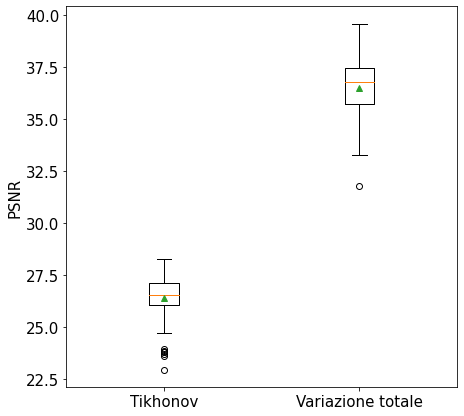

In [ ]:
plt.figure(figsize=(7, 7))

plt.boxplot(data, labels=["Naive", "Tikhonov", "Variazione totale"], showmeans=True)
plt.ylabel("PSNR")
plt.plot()

plt.show()


plt.figure(figsize=(7, 7))

boxplot2 = plt.boxplot(data2, labels=["Tikhonov", "Variazione totale"], showmeans=True, showfliers=True)
plt.ylabel("PSNR")
plt.plot()

plt.show()


In [ ]:
print("Tikhonov")
print("whiskers1", boxplot2["whiskers"][0].get_data())
print("whiskers2", boxplot2["whiskers"][1].get_data())
print("mean", boxplot2["means"][0].get_data())
print("median", boxplot2["medians"][0].get_data())
print("SD", np.std(psnr_tikhonov))
print()
print("TV")
print("whiskers1", boxplot2["whiskers"][2].get_data())
print("whiskers2", boxplot2["whiskers"][3].get_data())
print("mean", boxplot2["means"][1].get_data())
print("median", boxplot2["medians"][1].get_data())
print("SD", np.std(psnr_tv))


Tikhonov
whiskers1 (array([1., 1.]), array([26.03074889, 24.69643175]))
whiskers2 (array([1., 1.]), array([27.11161645, 28.24547429]))
mean (array([1]), array([26.39344772]))
median (array([0.925, 1.075]), array([26.52770018, 26.52770018]))
SD 1.0451613861676192

TV
whiskers1 (array([2., 2.]), array([35.71261477, 33.27423003]))
whiskers2 (array([2., 2.]), array([37.42812276, 39.58198616]))
mean (array([2]), array([36.48712539]))
median (array([1.925, 2.075]), array([36.7582896, 36.7582896]))
SD 1.3752327727591311


In [ ]:
data3 = [iter_naive, iter_tikhonov, iter_tv]
data4 = [iter_tikhonov, iter_tv]

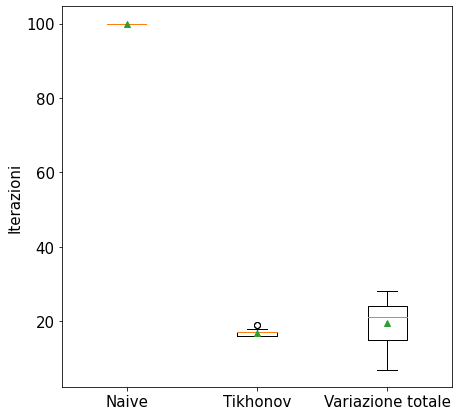

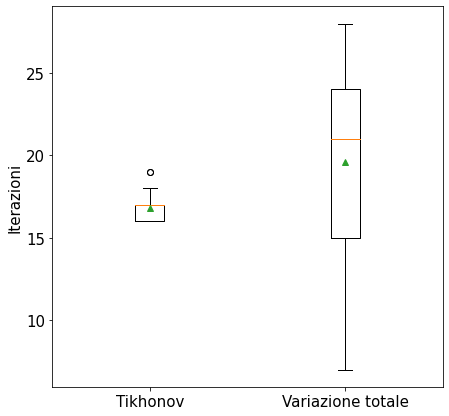

In [ ]:
plt.figure(figsize=(7, 7))

plt.boxplot(data3, labels=["Naive", "Tikhonov", "Variazione totale"], showmeans=True, showfliers=True)
plt.ylabel("Iterazioni")
plt.plot()

plt.show()

plt.figure(figsize=(7, 7))

boxplot4 = plt.boxplot(data4, labels=["Tikhonov", "Variazione totale"], showmeans=True, showfliers=True)
plt.ylabel("Iterazioni")
plt.plot()

plt.show()


In [ ]:
print("Tikhonov")
print("whiskers1", boxplot4["whiskers"][0].get_data())
print("whiskers2", boxplot4["whiskers"][1].get_data())
print("mean", boxplot4["means"][0].get_data())
print("median", boxplot4["medians"][0].get_data())
print("SD", np.std(iter_tikhonov))
print()
print("TV")
print("whiskers1", boxplot4["whiskers"][2].get_data())
print("whiskers2", boxplot4["whiskers"][3].get_data())
print("mean", boxplot4["means"][1].get_data())
print("median", boxplot4["medians"][1].get_data())
print("SD", np.std(iter_tv))


Tikhonov
whiskers1 (array([1., 1.]), array([16., 16.]))
whiskers2 (array([1., 1.]), array([17., 18.]))
mean (array([1]), array([16.79]))
median (array([0.925, 1.075]), array([17., 17.]))
SD 0.7522632517942106

TV
whiskers1 (array([2., 2.]), array([15.,  7.]))
whiskers2 (array([2., 2.]), array([24., 28.]))
mean (array([2]), array([19.59]))
median (array([1.925, 2.075]), array([21., 21.]))
SD 5.468262978314046


# Esecuzioni su dataset

In [169]:
real_images = []
images = []
blurs = []

kernel_len = 5
kernel_sigma = 0.5

noise_dev = 0.05

for i in range(1, 9):
    real_images = real_images + [plt.imread(f"./dataset/image{i}.png").astype(np.float64)]

for i in range(len(real_images)):
    blurs = blurs + [gaussian_blur(real_images[i].shape, kernel_len, kernel_sigma)]
    noise = np.random.normal(size=real_images[i].shape) * noise_dev
    images = images + [A(real_images[i], blurs[i]) + noise]


In [176]:
outs_naive = []
outs_tikhonov = []
outs_tv = []
lambda_tikhonov = 0.19
lambda_tv = 0.07

for i in range(len(images)):
    print(i, end=" ")
    outs_naive = outs_naive + [deblur_naive(images[i], blurs[i], max_iter=50)]
    outs_tikhonov = outs_tikhonov + [deblur_tikhonov_cg(images[i], blurs[i], lambda_tikhonov)]
    outs_tv = outs_tv + [deblur_tv(images[i], blurs[i], lambda_tv)]


0 1 2 3 4 5 6 7 

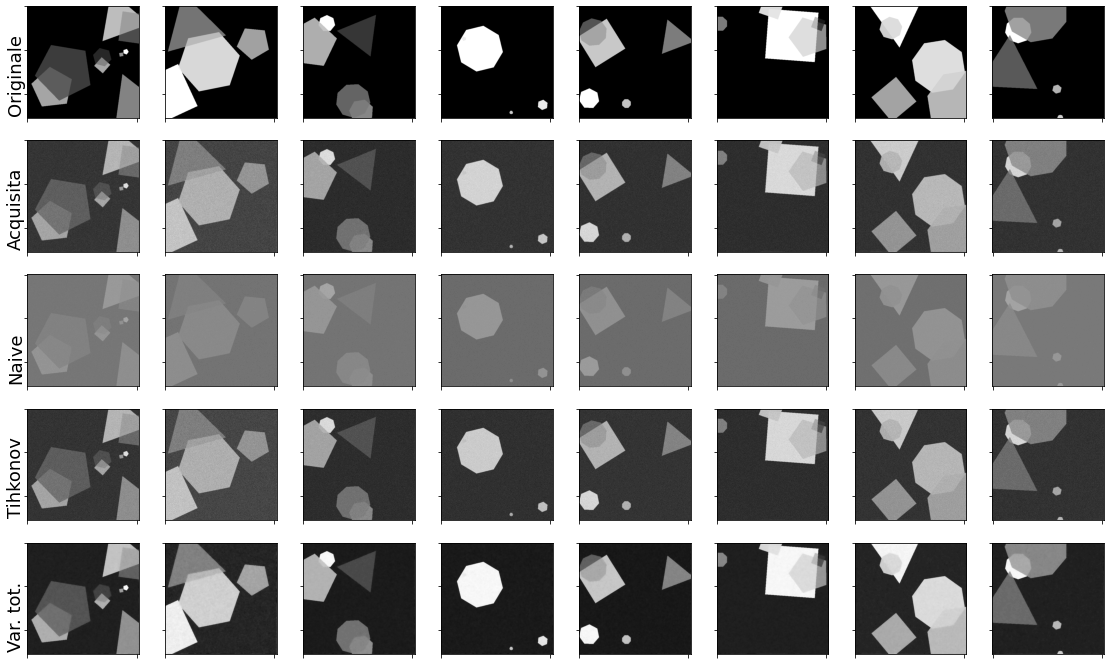

In [177]:
fig, ax = plt.subplots(5, 8, figsize=(150, 150))
fig.subplots_adjust(top=0.06, bottom=0, right=0.1, left=0)

for i in range(8):
    ax[0, i].imshow(real_images[i], cmap="gray")
    ax[0, i].set_xticklabels([])
    ax[0, i].set_yticklabels([])

    ax[1, i].imshow(images[i], cmap="gray")
    ax[1, i].set_xticklabels([])
    ax[1, i].set_yticklabels([])

    ax[2, i].imshow(outs_naive[i]["image"], cmap="gray")
    ax[2, i].set_xticklabels([])
    ax[2, i].set_yticklabels([])

    ax[3, i].imshow(outs_tikhonov[i]["image"], cmap="gray")
    ax[3, i].set_xticklabels([])
    ax[3, i].set_yticklabels([])

    ax[4, i].imshow(outs_tv[i]["image"], cmap="gray")
    ax[4, i].set_xticklabels([])
    ax[4, i].set_yticklabels([])

ax[0, 0].set_title("Originale", rotation='vertical', x=-0.1, y=0.01)
ax[1, 0].set_title("Acquisita", rotation='vertical', x=-0.1, y=0.01)
ax[2, 0].set_title("Naive", rotation='vertical', x=-0.1, y=0.01)
ax[3, 0].set_title("Tihkonov", rotation='vertical', x=-0.1, y=0.01)
ax[4, 0].set_title("Var. tot.", rotation='vertical', x=-0.1, y=0.01)
plt.show()


In [178]:
mses_naive = [np.format_float_scientific(metrics.mean_squared_error(real_images[i], outs_naive[i]["image"]), 5) for i in range(len(images))]
psnrs_naive = [round(metrics.peak_signal_noise_ratio(real_images[i], outs_naive[i]["image"]), 4) for i in range(len(images))]

mses_tikhonov = [np.format_float_scientific(metrics.mean_squared_error(real_images[i], outs_tikhonov[i]["image"]), 5) for i in range(len(images))]
psnrs_tikhonov = [round(metrics.peak_signal_noise_ratio(real_images[i], outs_tikhonov[i]["image"]), 4) for i in range(len(images))]

mses_tv = [np.format_float_scientific(metrics.mean_squared_error(real_images[i], outs_tv[i]["image"]), 5) for i in range(len(images))]
psnrs_tv = [round(metrics.peak_signal_noise_ratio(real_images[i], outs_tv[i]["image"]), 4) for i in range(len(images))]


In [179]:
print(f"Kernel {kernel_len}x{kernel_len} sigma={kernel_sigma} | noise {noise_dev}")
print(f"{'MSE naive':<15} {'MSE Tikhonov':<15} {'MSE TV':<15} {'PSNR naive':<15} {'PSNR Tikhonov':<15} {'PSNR TV':<15} {'Iter. naive':<15} {'Iter Tikhonov':<15} {'Iter tv':<15}")

for i in range(len(images)):
    print(f"{mses_naive[i]:<15} {mses_tikhonov[i]:<15} {mses_tv[i]:<15} {psnrs_naive[i]:<15} {psnrs_tikhonov[i]:<15} {psnrs_tv[i]:<15} {outs_naive[i]['n_it']:<15} {outs_tikhonov[i]['n_it']:<15} {outs_tv[i]['n_it']:<15}")

print()
print(f"{'Media PSNR Naive':<25} {np.mean(psnrs_naive)}")
print(f"{'Media PSNR Tikhonov':<25} {np.mean(psnrs_tikhonov)}")
print(f"{'Media PSNR TV':<25} {np.mean(psnrs_tv)}")
print()
print(f"{'SD PSNR Naive':<25} {np.std(psnrs_naive)}")
print(f"{'SD PSNR Tikhonov':<25} {np.std(psnrs_tikhonov)}")
print(f"{'SD PSNR TV':<25} {np.std(psnrs_tv)}")


Kernel 5x5 sigma=0.5 | noise 0.05
MSE naive       MSE Tikhonov    MSE TV          PSNR naive      PSNR Tikhonov   PSNR TV         Iter. naive     Iter Tikhonov   Iter tv        
1.94468e-01     3.31935e-03     2.08768e-04     7.1115          24.7895         36.8034         50              14              16             
1.94072e-01     3.13483e-03     1.64655e-04     7.1204          25.0379         37.8343         50              13              16             
1.96285e-01     3.47859e-03     1.88653e-04     7.0711          24.586          37.2434         50              14              18             
1.9301e-01      3.89598e-03     2.22505e-04     7.1442          24.0938         36.5266         50              15              12             
1.93637e-01     3.56997e-03     2.74617e-04     7.1301          24.4734         35.6127         50              14              10             
1.91011e-01     5.65795e-03     1.84929e-04     7.1894          22.4734         37.33           50    

In [180]:
print(
f"""
\\begin{{center}}
    \\begin{{tabular}}{{ |c|c|c|c|c|c|c|c|c|c| }}
    \\hline
    & MSE naive & MSE Tikhonov & MSE Var. tot. & PSNR naive & PSNR Tikhonov & PSNR var. tot. & It. naive & It. Tikhonov & It. var.tot \\\\ 
    \\hline
"""
)

for i in range(len(images)):
    print(f"\t& {mses_naive[i]} & {mses_tikhonov[i]} & {mses_tv[i]} & {psnrs_naive[i]} & {psnrs_tikhonov[i]} & {psnrs_tv[i]} & {outs_naive[i]['n_it']} & {outs_tikhonov[i]['n_it']} & {outs_tv[i]['n_it']} \\\\")

print(
f"""
    \\hline
    \\end{{tabular}}
\\end{{center}}
"""
)



\begin{center}
    \begin{tabular}{ |c|c|c|c|c|c|c|c|c|c| }
    \hline
    & MSE naive & MSE Tikhonov & MSE Var. tot. & PSNR naive & PSNR Tikhonov & PSNR var. tot. & It. naive & It. Tikhonov & It. var.tot \\ 
    \hline

	& 1.94468e-01 & 3.31935e-03 & 2.08768e-04 & 7.1115 & 24.7895 & 36.8034 & 50 & 14 & 16 \\
	& 1.94072e-01 & 3.13483e-03 & 1.64655e-04 & 7.1204 & 25.0379 & 37.8343 & 50 & 13 & 16 \\
	& 1.96285e-01 & 3.47859e-03 & 1.88653e-04 & 7.0711 & 24.586 & 37.2434 & 50 & 14 & 18 \\
	& 1.9301e-01 & 3.89598e-03 & 2.22505e-04 & 7.1442 & 24.0938 & 36.5266 & 50 & 15 & 12 \\
	& 1.93637e-01 & 3.56997e-03 & 2.74617e-04 & 7.1301 & 24.4734 & 35.6127 & 50 & 14 & 10 \\
	& 1.91011e-01 & 5.65795e-03 & 1.84929e-04 & 7.1894 & 22.4734 & 37.33 & 50 & 13 & 17 \\
	& 1.93223e-01 & 5.74728e-03 & 2.33547e-04 & 7.1394 & 22.4054 & 36.3163 & 50 & 12 & 19 \\
	& 1.92628e-01 & 2.88102e-03 & 1.57182e-04 & 7.1528 & 25.4045 & 38.036 & 50 & 13 & 13 \\

    \hline
    \end{tabular}
\end{center}



# Relazione

1.   Riportare e commentare i risultati ottenuti nei punti 2. 3. (e 4.) su un immagine del set creato e su altre due immagini in bianco e nero  (fotografiche/mediche/astronomiche)
2.   Riportare delle tabelle con le misure di PSNR e MSE ottenute al variare dei parametri (dimensione kernel, valore di sigma, la deviazione standard del rumore, il parametro di regolarizzazione). 
3. Calcolare sull’intero set di immagini medie e deviazione standard delle metriche per alcuni valori fissati dei parametri.  
4. Analizzare su 2 esecuzioni le proprietà dei metodi numerici utilizzati (gradiente coniugato e gradiente) in termini di numero di iterazioni, andamento dell’errore, della funzione obiettivo, norma del gradiente. 

